[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/hometask_SyntheticRubber.ipynb)

In [1]:
##### При работе в Colab
!pip install yfinance requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 729 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from tqdm.auto import tqdm

In [3]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

In [4]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [5]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже
#
year = '2022'
month = '05'
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)
df.head()

,date,grade,masa,rm,us,tone
0,2022-05-31,SMR CV,Noon,1157.50,269.20,Slightly steadier
1,2022-05-31,SMR L,Noon,1147.50,266.90,Slightly steadier
2,2022-05-31,SMR 5,Noon,740.00,172.10,Slightly steadier
3,2022-05-31,SMR GP,Noon,737.00,171.40,Slightly steadier
4,2022-05-31,SMR 10,Noon,730.00,169.80,Slightly steadier


In [7]:
year = ['2020','2021','2022']
month = ['1','2','3','4','5','6','7','8','9','10','11','12']
dfs = []

for i in year:
    for j in month:
        url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={j}&year={i}"
        res = requests.get(url)
        rj = res.json()
        df = pd.json_normalize(rj)
        dfs.append(df)

In [8]:
df1 = pd.concat(dfs)       
df1.head()

,date,grade,masa,rm,us,tone
0,2020-01-31,SMR CV,Noon,767.50,190.70,Quiet
1,2020-01-31,SMR L,Noon,757.50,188.20,Quiet
2,2020-01-31,SMR 5,Noon,562.50,139.75,Quiet
3,2020-01-31,SMR GP,Noon,559.50,139.00,Quiet
4,2020-01-31,SMR 10,Noon,552.50,137.25,Quiet


In [22]:
df_smr20 = df1[df1.grade == 'SMR 20'].reset_index()
df_smr20 = df_smr20[['date', 'us']]
df_smr20.columns = ['date','USD_rubber']
df_smr20.head()

,date,USD_rubber
0,2020-01-31,136.75
1,2020-01-30,136.45
2,2020-01-29,136.25
3,2020-01-28,136.95
4,2020-01-23,147.05


In [23]:
import datetime
from datetime import datetime, date, time
df_smr20.date=pd.to_datetime(df_smr20.date)
df_smr20['month_year'] = df_smr20['date'].dt.to_period('M')
df_smr20['USD_rubber'] = df_smr20['USD_rubber'].astype(float)
df_agg = df_smr20.groupby('month_year').agg({'USD_rubber':'mean'}).reset_index()
df_agg.head()

,month_year,USD_rubber
0,2020-01,146.960000
1,2020-02,134.165000
2,2020-03,122.436364
3,2020-04,110.319048
4,2020-05,110.046875


In [24]:
df_dict = {}
for ticker in tqdm(['USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df = yf.download(ticker)
    df = df.Close.copy()
    df = df.resample('M').mean()
    df_dict[ticker] = df

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
main_df = pd.concat(df_dict.values(), axis=1).reset_index()
main_df.columns = ['date', 'USDRUB', 'EURUSD', 'EURRUB']
main_df = main_df.loc[(main_df['date'] >= '2019-01-31') & (main_df['date'] <= '2022-08-31')].reset_index()
main_df['month_year'] = main_df['date'].dt.to_period('M')
main_df = main_df[['month_year','USDRUB','EURUSD', 'EURRUB']]
main_df.head()

,month_year,USDRUB,EURUSD,EURRUB
0,2019-01,66.883992,1.142533,76.434270
1,2019-02,65.778695,1.135397,74.735620
2,2019-03,65.115486,1.130985,73.674074
3,2019-04,64.569977,1.123492,72.561023
4,2019-05,64.876098,1.118911,72.577653


In [26]:
df_finally = main_df.merge(df_agg, on=["month_year"])
df_finally.head()

,month_year,USDRUB,EURUSD,EURRUB,USD_rubber
0,2020-01,61.828313,1.111180,68.664805,146.960000
1,2020-02,63.991130,1.091091,69.840279,134.165000
2,2020-03,74.244732,1.107309,82.130068,122.436364
3,2020-04,75.222187,1.087575,81.777489,110.319048
4,2020-05,72.904476,1.089994,79.473057,110.046875


In [27]:
df_finally['MWP_PRICE_EUR'] = df_finally.USD_rubber * (1/df_finally.EURUSD) + 400 
df_finally['MWP_PRICE_USD'] = df_finally.USD_rubber + 400 * df_finally.EURUSD 
df_finally['MWP_PRICE_EUR_EU'] = df_finally['MWP_PRICE_EUR'] + EU_LOGISTIC_COST_EUR 
df_finally['MWP_PRICE_USD_CN'] = df_finally['MWP_PRICE_USD'] + CN_LOGISTIC_COST_USD 
df_finally['MWP_PRICE_EUR_EU_MA'] = df_finally.MWP_PRICE_EUR_EU.rolling(window=3).mean() 
df_finally.head()

,month_year,USDRUB,EURUSD,EURRUB,USD_rubber,MWP_PRICE_EUR,MWP_PRICE_USD,MWP_PRICE_EUR_EU,MWP_PRICE_USD_CN,MWP_PRICE_EUR_EU_MA
0,2020-01,61.828313,1.111180,68.664805,146.960000,532.255767,591.432110,562.255767,721.432110,NaN
1,2020-02,63.991130,1.091091,69.840279,134.165000,522.964116,570.601269,552.964116,700.601269,NaN
2,2020-03,74.244732,1.107309,82.130068,122.436364,510.571128,565.359812,540.571128,695.359812,551.930337
3,2020-04,75.222187,1.087575,81.777489,110.319048,501.435806,545.349051,531.435806,675.349051,541.657017
4,2020-05,72.904476,1.089994,79.473057,110.046875,500.961004,546.044420,530.961004,676.044420,534.322646


In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

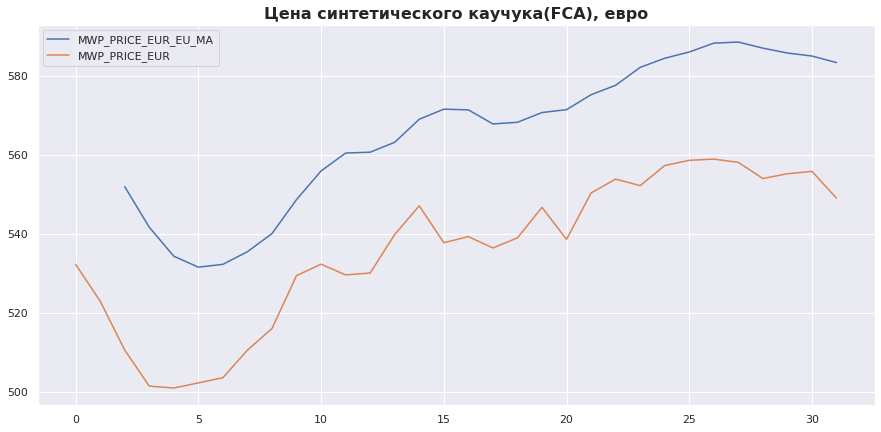

In [32]:
# График с базовой ценой(на заводе) в евро
plt.title('Цена синтетического каучука(FCA), евро', fontsize=16, fontweight='bold')
plt.plot(df_finally['MWP_PRICE_EUR_EU_MA'], label='MWP_PRICE_EUR_EU_MA')
plt.plot(df_finally['MWP_PRICE_EUR'], label='MWP_PRICE_EUR')
plt.legend()
plt.show()

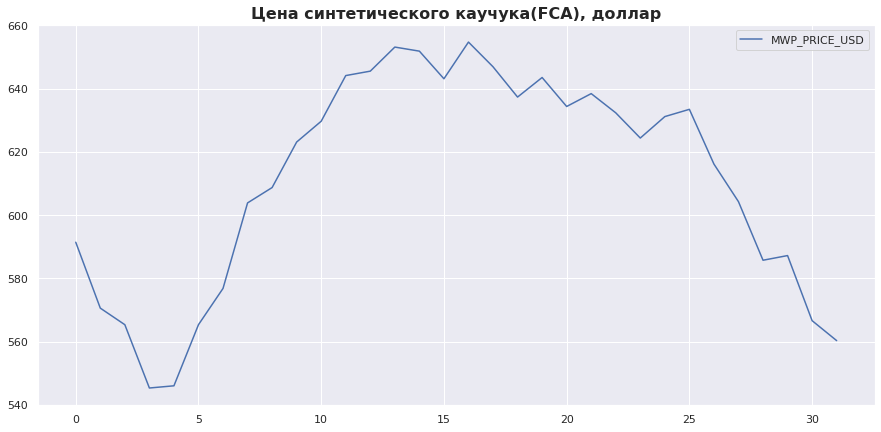

In [33]:
# График с базовой ценой(на заводе) в долларах
plt.title('Цена синтетического каучука(FCA), доллар', fontsize=16, fontweight='bold')
plt.plot(df_finally['MWP_PRICE_USD'], label='MWP_PRICE_USD')
plt.legend()
plt.show()

In [34]:
customers

{'Monty': {'formula': 'moving_average', 'location': 'EU', 'volumes': 200},
 'Poly': {'formula': 'monthly', 'location': 'EU', 'volumes': 70},
 'Stone': {'formula': 'moving_average', 'location': 'EU', 'volumes': 150},
 'Triangle': {'formula': 'monthly', 'location': 'CN', 'volumes': 30}}

In [37]:
discounts = {100: 0.01, 300: 0.05, 301: 0.1}

In [38]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 5.2 MB/s 


In [42]:
import os

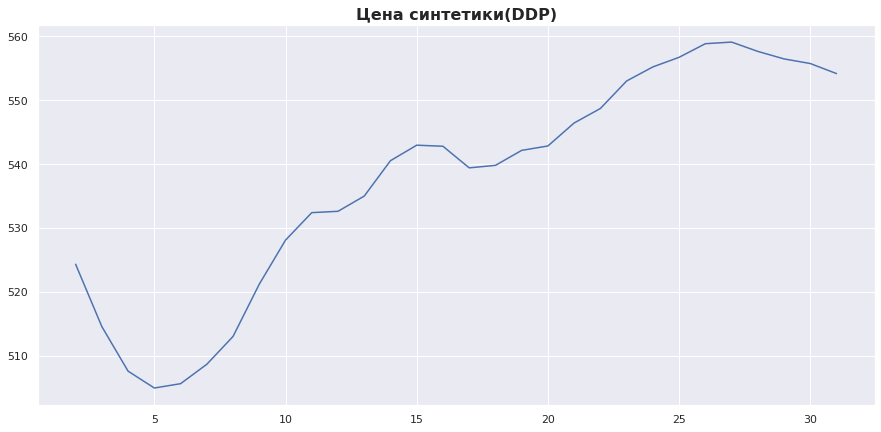

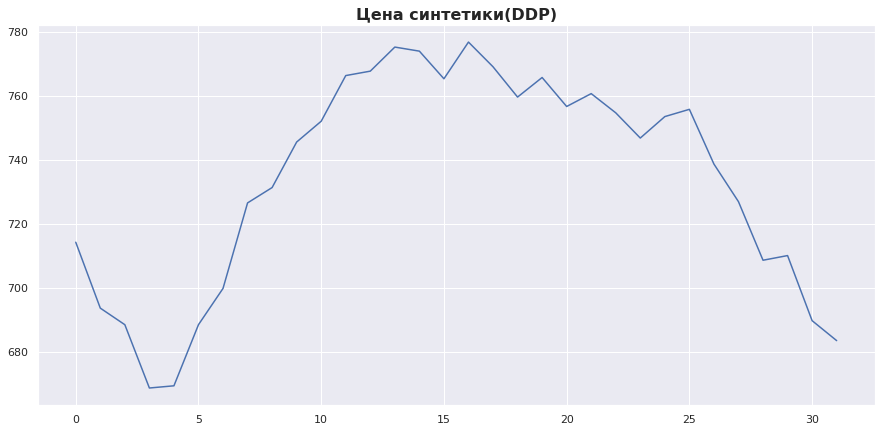

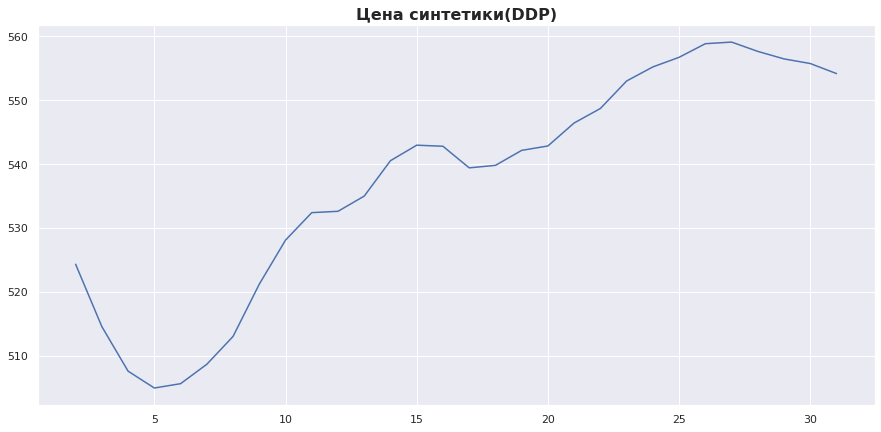

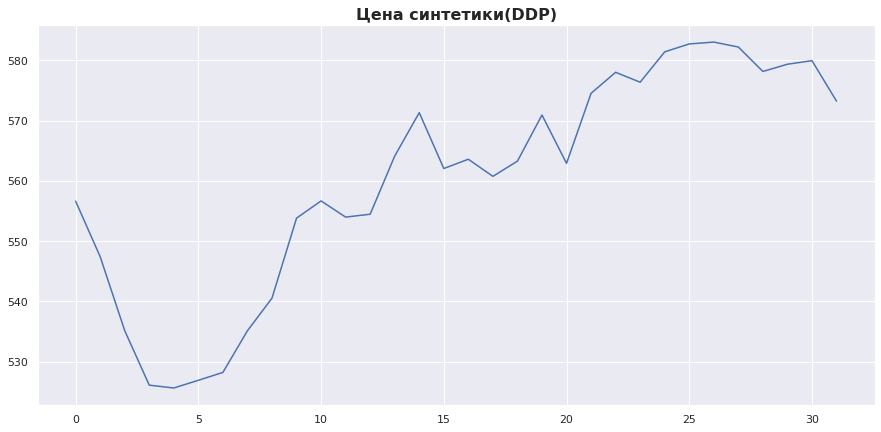

In [43]:
with pd.ExcelWriter('price_proposals.xlsx', engine = 'xlsxwriter') as writer:
    for client, v in customers.items():

        disc = 0.0
        if v.get('location') == "EU":
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            if v.get('formula') == 'monthly':
                client_price = df_finally['MWP_PRICE_EUR_EU'] * (1-disc)
            elif v.get('formula') == 'moving_average':
                client_price = df_finally['MWP_PRICE_EUR_EU_MA'] * (1-disc)

        elif v.get('location') == 'CN':
            fl = 0
            for k_lim, discount_share in discounts.items():
                if v.get('volumes') > k_lim:
                    continue
                else:
                    disc = discount_share
                    fl = 1
                    break
            if fl == 0 :
                disc = discounts.get(max(discounts.keys()))

            client_price = df_finally['MWP_PRICE_USD_CN'] * (1-disc)

        # print(client, v, disc)
        client_price.to_excel(writer, sheet_name=client)
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена синтетики(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        # worksheet = writer.sheets[client]
        # worksheet.insert_image('C2',plot_path)

    for k,v in customers.items():
        worksheet = writer.sheets[k]
        worksheet.insert_image('C2',f"{k}_wbp.png")

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.



* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [45]:
# Создаем директорию для ценовых предложений клиентам
price_proposals_path = 'client_price_proposals'
if not os.path.exists(price_proposals_path):
    os.mkdir(price_proposals_path)

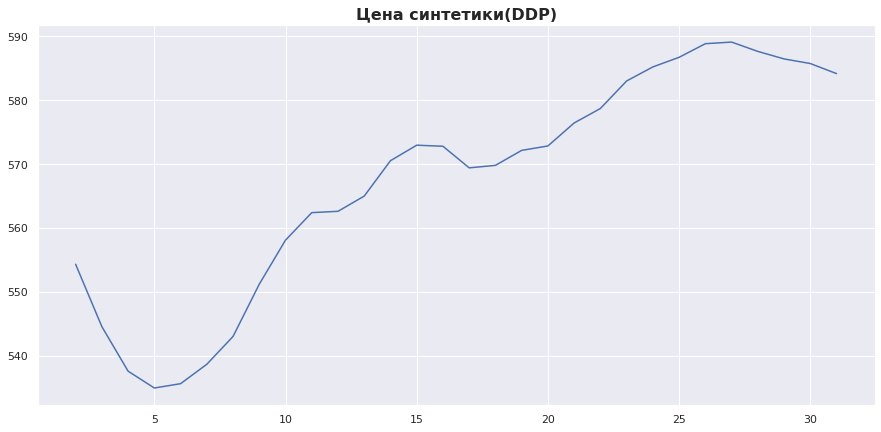

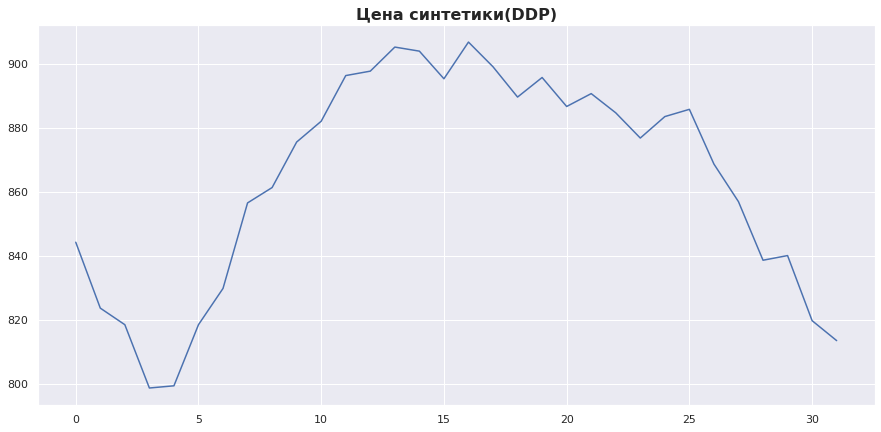

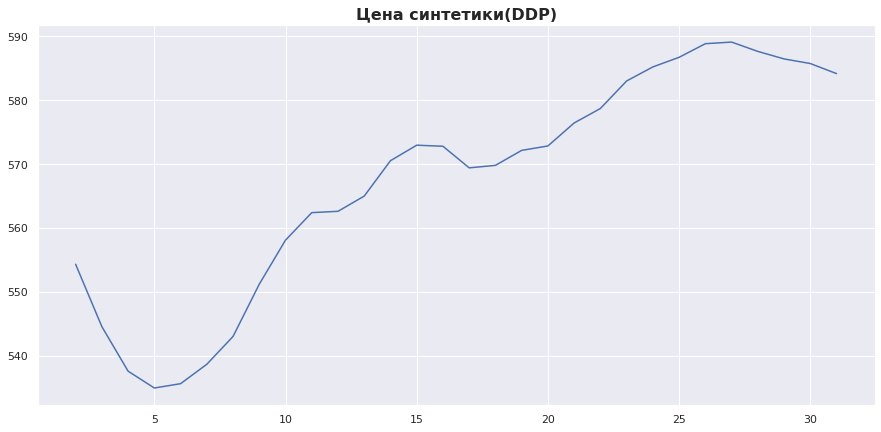

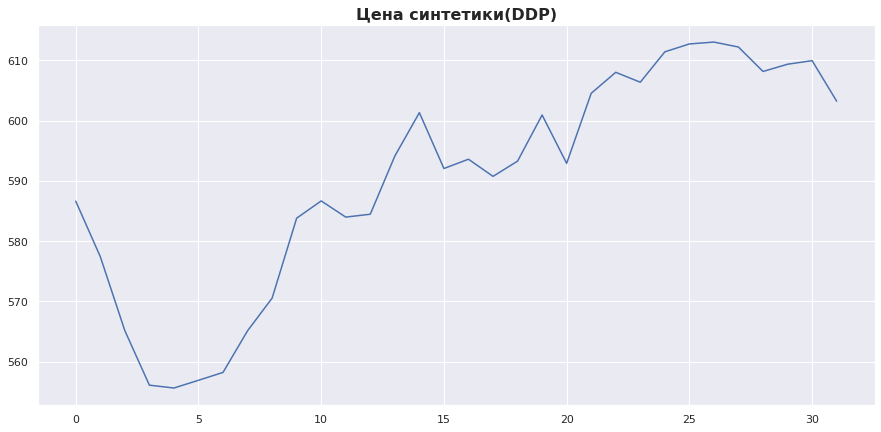

In [48]:
# Создаем отдельный файл для каждого из клиентов
for client, v in customers.items():
    client_proposal_file_path = os.path.join(price_proposals_path, f'{client}_mwp_price_proposal.xlsx')
    location = v.get('location')
    disc = 0.0
    if v.get('location') == "EU":
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        if v.get('formula') == 'monthly':
            client_price = df_finally['MWP_PRICE_EUR_EU'] * (1-disc) + EU_LOGISTIC_COST_EUR
        elif v.get('formula') == 'moving_average':
            client_price = df_finally['MWP_PRICE_EUR_EU_MA'] * (1-disc) + EU_LOGISTIC_COST_EUR

    elif v.get('location') == 'CN':
        fl = 0
        for k_lim, discount_share in discounts.items():
            if v.get('volumes') > k_lim:
                continue
            else:
                disc = discount_share
                fl = 1
                break
        if fl == 0 :
            disc = discounts.get(max(discounts.keys()))

        client_price = df_finally['MWP_PRICE_USD_CN'] * (1-disc) + CN_LOGISTIC_COST_USD
    with pd.ExcelWriter(client_proposal_file_path, engine='xlsxwriter') as writer:
        client_price.to_excel(writer, sheet_name='price_proposal')
        # Добавляем график с ценой
        plot_path = f'{client}_wbp.png'
        plt.title('Цена синтетики(DDP)', fontsize=16, fontweight='bold')
        plt.plot(client_price)
        plt.savefig(plot_path)
        plt.show()
        worksheet = writer.sheets['price_proposal']
        worksheet.insert_image('C2',plot_path)

for k,v in customers.items():
    if os.path.exists(f"{k}_wbp.png"):
        os.remove(f"{k}_wbp.png")

# Задание 3. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

### Что нужно сделать?
* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ
* Помните о PEP8

In [ ]:
# import yourpackage

# Задание 4. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

### Что нужно сделать?
* Создайте отдельный пакет, который можно устанавливать с помощью pip
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в свой репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage